<a href="https://www.coursera.org/learn/applied-data-science-capstone/"><img src = "https://seetorontonow.mx/uploads/2018/01/kayak-on-lake-ontario-looking-at-toronto-skyline.jpg" width = 500> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
<h1 align=center><font size = 4>By Miguel Lira Vidrio</font></h1>
<h1 align=center><font size = 2.5>For Coursera Applied Data Science Capstone</font></h1>

## Introduction
In this notebook is presented a work around Toronto Neighborhoods to understand their characteristics and segmenting them.
The neighborhoods information was obteined from Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and grouping by Postalcode. Also the geo coordinates was added to each Postalcode. The Foursquare API was used to get venues around of the PostalCode Coordinates. With the collected information a dataframe was built and included top 10 venues categories for each postalcode, venues density per square meters. Finally we applied a kmeans algorithm.  

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Create Toronto Neighborhoods Dataframe</a>

2. <a href="#item2">Get PostalCode Coordinates</a>

3. <a href="#item3">Get Venues from Foursquare API</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Results</a>    
</font>
</div>

##### Install and import libraries:

In [1]:
!pip install tensorflow
!pip install geopy
!pip install folium
!pip install bs4
!pip install googlemaps


    100% |████████████████████████████████| 1.6MB 20.1MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 26.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 0.999999999
    Uninstalling html5lib-0.999999999:
      Successfully uninstalled html5lib-0.999999999
  Found existing installation: bleach 2.0.0
    Uninstalling bleach-2.0.0:
      Successfully uninstalled bleach-2.0.0
    100% |████████████████████████████████| 92kB 15.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for bs4 ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
  Running setup.py bdist_wheel for googlemaps ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import json
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup #Library to scraping info. from a web portal such a wikipedia.


print('Libraries are correctly imported')

Libraries are correctly imported


## 1. Create Toronto Neighborhoods DataFrame

The Toronto Neighborhoods information is available in the following Wikipedia Page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
BeautifulScrape was used to scrape the table content. A pandas dataframe was built from content in order to know which Neighborhoods belongs to a PostalCode and Borough with the follow structure:
<img src="https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/7JXaz3NNEeiMwApe4i-fLg_40e690ae0e927abda2d4bde7d94ed133_Screen-Shot-2018-06-18-at-7.17.57-PM.png?expiry=1559779200000&hmac=dyAVJgKU6e2BrXIIHUTkjX3L4kgDdkzjFF2IEV6tmP4" width = 400>

In the table on the Wikipedia page, is possible see that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. For our purpuse these two rows was combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

Also the Wikipedia table has PostalCode with Not assigned Boroughs and Neighborhoods. The analysis required process the cells that had an assigned borough. When a PostalCode had borough but a Not assigned neighborhood, the neighborhood was replaced with borough name. 

In the next cells the code to create the desire dataframe is presented.


1) Toronto Neighborhood Data from Wikipedia was processed to a Dataframe.

In [3]:
#Scrape content from Wikipedia table:
url=requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(url,"html.parser")
tb = soup.find('table', class_='wikitable')
rows = tb.find_all('tr')
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
#Create a pandas dataframe: 
toronto_df=pd.DataFrame(l, columns=["PostalCode", "Borough","Neighborhood"])
toronto_df=toronto_df.drop([0])
toronto_df=toronto_df.reset_index(drop=True)
#Replace dirty string:
toronto_df["Neighborhood"]=toronto_df["Neighborhood"].str.replace('\n', '')

2) Only assigned Boroughs were selected. All "Not assigned" Neighborhood records were replaced with the correspondent Borough name.

In [4]:
totalPost=toronto_df["PostalCode"].unique().shape[0]
toronto_df=toronto_df.loc[toronto_df["Borough"]!="Not assigned"]
index=toronto_df.loc[toronto_df["Neighborhood"]=="Not assigned"].index.values.astype(int)
for i in index:
    toronto_df.at[i, 'Neighborhood'] = toronto_df.at[i, 'Borough']
PC=toronto_df["PostalCode"].unique().shape[0]
PC_na_Boroughs=totalPost-PC

3) Adjusted DataFrame to contains Borough, Postalcode and a list of related Neighborhoods separated with coma.

In [5]:
toronto_df=toronto_df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(lambda x:"%s" % ", ".join(x)).to_frame()
toronto_df.reset_index(level=1, inplace=True)
toronto_df.reset_index(level=0, inplace=True)

4) In the follow cell the results from the code are presented:

In [6]:
print("At the beginning we had: {} Postalcodes.".format(totalPost))
print('A total of {} PostalCodes was discarded.'.format(PC_na_Boroughs))
print("Only {} Neighborhoods was replaced with the Borough Name.".format(index.shape[0]))
print("The final shape of our dataframe is {}".format(toronto_df.shape))

At the beginning we had: 180 Postalcodes.
A total of 77 PostalCodes was discarded.
Only 1 Neighborhoods was replaced with the Borough Name.
The final shape of our dataframe is (103, 3)


In [7]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood
82,M6P,West Toronto,"High Park, The Junction South"
20,M2L,North York,"Silver Hills, York Mills"
83,M6R,West Toronto,"Parkdale, Roncesvalles"
38,M4G,East York,Leaside
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter"
4,M1H,Scarborough,Cedarbrae
12,M1S,Scarborough,Agincourt
42,M4L,East Toronto,"The Beaches West, India Bazaar"
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi..."


## 2. Get PostalCode Coordinates

The dataframe created with Wikipedia table content do not possess coordinates for every single PostalCode. Unfortunately, the foursquare API works better with coordinates.
Googlemaps library was used to get latitude and longitude coordinates for each PostalCode. In the cells below the steps followed to get coordinates are presented.

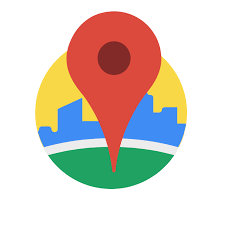

1) First the googlemaps library was added. Also in order to obtain better results in the location of coordinates directions variable was created.

In [8]:
import googlemaps
directions=toronto_df["PostalCode"]+ ", ONTARIO, CANADA"

2) The Google Cloud Secret Key was specified.

In [9]:
# The code was removed by Watson Studio for sharing.

3) Latitude and longitude were got from grocode API and added to the Toronto_Neighborhood Dataframe.

In [10]:
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
toronto_df["Latitude"]=lat
toronto_df["Longitude"]=long

4) In the next cell is possible see the resultant dataframe from the code above.

In [11]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
63,M5N,Central Toronto,Roselawn,43.711695,-79.416936
33,M3N,North York,Downsview Northwest,43.761631,-79.520999
91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509
36,M4C,East York,Woodbine Heights,43.695344,-79.318389
3,M1G,Scarborough,Woburn,43.770992,-79.216917
55,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
97,M9M,North York,"Emery, Humberlea",43.724766,-79.532242
83,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325


## 3. Get Veneus from Foursquare API

This section contains the steps followed to get venues from Foursquare in a properly way. Initially it was thought to work the parameters defined in the Segmenting and Clustering New York Neighborhoods I mean 500 meters of radius in every search. To not take risks this section has two parts:

1) Data exploration and refinement
2) Get Venues from Foursquare.


<img src="https://ss0.4sqi.net/img/developers/products/places-api-538e392a138bea16aa61260a55a875b4.png" width = 200>


#### 3.1. Data Exploration

1) Firstly a folium map was generated to understand the Toronto PostalCodes distribution.

In [12]:
address = 'Toronto, ONTARIO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of TORONTO City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of TORONTO City are 43.653963, -79.387207.


In [13]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

2) The parameter used in New York Neighborhoods (radious=500 meters) was added to Toronto_map

In [14]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and radious to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=500,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

As the first Toronto Map shown, is confirmed in the map above that in many Postalcode a radious of 500 meters could left behind a lot of venue. Is possible identify a lot of Postalcode overlaping.
To solve the radious problem the GeoPy.Distance.greatCircle was used.

##### Additional Information about how get an properly radious:
Nearest Location:
https://stackoverflow.com/questions/49323171/find-the-nearest-location-using-numpy
Geopy.distance example:
https://www.programcreek.com/python/example/96855/geopy.distance.vincenty
Best way to compute distance:
https://geopy.readthedocs.io/en/stable/#module-geopy.distance


3) The Geopy.Distance.Greatcircle library was loaded and a function to find the nearest postalcode for each location was created.

In [15]:
from geopy.distance import great_circle
def find_closest_location(origin, locations):
    locations=np.asarray(locations)
    origin=np.asarray(origin).reshape(1,-1)
    i=len(locations)
    distances=np.zeros(i)
    for j in range(i):
        distances[j] = great_circle(origin, locations[j]).meters
    closest = np.argmin(distances)
    return [round(distances[closest]), closest]

Once the function was created a test was performed to know if the gottan data was correct.

In [16]:
locations=toronto_df[["Latitude", "Longitude"]]
meters, index=find_closest_location(locations[:1], locations[~locations.index.isin([0])])
close_point = locations[:1].append(locations[index+1:index+2])
points=np.asarray(close_point)
print("The distance between {} postalcode and the nearest neighbor ({} postalcode) is: {} meters".format(toronto_df["PostalCode"][0],toronto_df["PostalCode"][index+1], meters) )

The distance between M1B postalcode and the nearest neighbor (M1X postalcode) is: 3397.0 meters


In the cell below is possible see the code and the resultant map to show 

In [17]:
test_data=toronto_df
i=len(test_data)
tested=np.zeros(i)
tested[0]=1
tested[index+1]=1
tested=np.int64(tested)
test_data["Test"]=tested
colors = ["blue", "red"]

Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers and radious to map
for lat, lng, borough, neighborhood, tested in zip(test_data['Latitude'], test_data['Longitude'], test_data['Borough'], test_data['PostalCode'], test_data["Test"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=None,
        fill=True,
        fill_color=colors[tested],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
folium.PolyLine(points, color="red", label = meters, weight=2.5, opacity=1).add_to(Toronto_map)
Toronto_map 



4) he function to iterate into each coordinate and get_radious was created.

In [18]:
def get_radious(df, locations):
    for lat, lng, idx in zip(df['Latitude'], df['Longitude'], df.index):
        meters, index = find_closest_location([lat,lng], locations[~locations.index.isin([idx])])
        df.at[idx,'Radious'] = np.int64(meters//2)
    return df

In [19]:
df_4square=get_radious(toronto_df, locations)
df_4square.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Test,Radious
38,M4G,East York,Leaside,43.709060,-79.363452,0,602.0
69,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,0,111.0
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,0,1480.0
58,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,150.0
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0,1559.0
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724,0,993.0
40,M4J,East York,East Toronto,43.685347,-79.338106,0,651.0
21,M2M,North York,"Newtonbrook, Willowdale",43.789053,-79.408493,0,911.0
66,M5S,Downtown Toronto,"Harbord, University of Toronto",43.662696,-79.400049,0,425.0
53,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,614.0


In [20]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radious to map
for lat, lng, borough, neighborhood, r in zip(df_4square['Latitude'], df_4square['Longitude'], df_4square['Borough'], df_4square['Neighborhood'], df_4square["Radious"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

#### 3.2 Get venues from Foursquare API